In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, LatentDirichletAllocation
import pandas as pd


In [23]:
data = fetch_20newsgroups()
print(data.target_names)
x, y = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), return_X_y=True)

#fixing dimensions (not working)
# x = np.array(x)
# y= np.array(y)
# x = x[:,np.newaxis]
# y = y[:,np.newaxis]

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


[480 584 591 590 578 593 585 594 598 597 600 595 591 594 593 599 546 564
 465 377]


([<matplotlib.axis.XTick at 0x2bf512c5570>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19')])

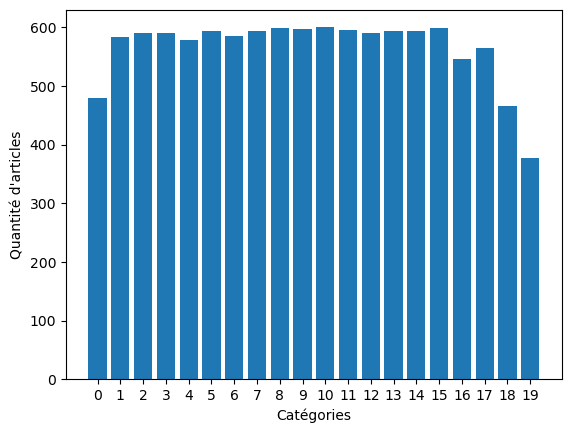

In [24]:
unique_labels = np.unique(y, return_counts=True)
print(unique_labels[1])
plt.bar(x=unique_labels[0], height=unique_labels[1])
plt.xlabel('Catégories')
plt.ylabel("Quantité d'articles")
plt.xticks(ticks=unique_labels[0])

In [25]:
cluster_number = len(np.unique(y))
cluster_number

20

In [26]:
# shamelessly stealing Adrien's nice function for clustering benchmark:, 

def bench_clust(estimator, data, name, ground_truth = None):
    estimator.fit(data)
    scores = [
        "adjusted_rand_score",
        "adjusted_mutual_info_score",
        "silhouette_score",
        "homogeneity_score",
        "completeness_score",
        "v_measure_score",
    ]
    results = []
    for s in scores:
        if s not in ["silhouette_score"]:
            #where ground truth is provided
            score = getattr(metrics, s)(ground_truth, estimator.labels_)
        elif ground_truth is not None:
            score = getattr(metrics, s)(data, estimator.labels_)
        else: 
            continue

        results.append(score)
    res = pd.DataFrame([results], columns=scores, index=[str(name)])
    return  res

In [28]:
#building train test split : 
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42)

# failed to build a pipeline, it seems to cause a data dimension error that does not occur while working "the handy way", 
# # using CountVectorizer to extract tokens matrix, and kmeans as a model, in a sequence.
vect = CountVectorizer()
x_train_vec = vect.fit_transform(x_train)

model = KMeans(n_clusters= cluster_number)

#let's give it a try : 
res1 = bench_clust(model, x_train_vec,'countvect and kmeans' ,y_train)

c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [29]:
res1

,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
countvect and kmeans,0.004115,0.024603,0.341883,0.019972,0.072655,0.031332


In [31]:
#test with tfidf and stop_words

better_vec = TfidfVectorizer(stop_words='english')
x_train_vec2 = better_vec.fit_transform(x_train)

#let's give it a try : 
res2 = bench_clust(model, x_train_vec2, 'tdidf and kmeans', y_train)

c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [32]:
res2 = pd.concat([res1, res2], axis=0, ignore_index=False)
res2

,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
countvect and kmeans,0.004115,0.024603,0.341883,0.019972,0.072655,0.031332
tdidf and kmeans,0.070749,0.314424,0.002873,0.289847,0.357007,0.319940


In [14]:
#test with tfidf and max_df
#### Don't Run this cell unless you want to take a long break #####
df_res = pd.DataFrame()

for i in range(10):
    n= 1 - (i/10)
    better_vec = TfidfVectorizer(max_df=n)
    x_train_vec2 = better_vec.fit_transform(x_train)
    results = bench_clust(model, x_train_vec2, n, y_train)
    df_res = pd.concat([df_res, results], axis=0, ignore_index=False)
    df_res



c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

In [33]:
df_res

,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
1.0,0.073252,0.286227,-0.006788,0.256639,0.339331,0.292248
0.99,0.089396,0.268029,-0.005882,0.249040,0.304593,0.274029
0.98,0.057131,0.220411,-0.006202,0.197820,0.266674,0.227143
0.97,0.063384,0.271173,-0.005378,0.236141,0.336772,0.277619
0.96,0.057670,0.225895,-0.007245,0.204152,0.269798,0.232429
0.95,0.076944,0.239131,-0.006744,0.218933,0.279401,0.245498
0.94,0.070058,0.238348,-0.006419,0.215804,0.282809,0.244804
0.9299999999999999,0.086405,0.282864,-0.001171,0.257802,0.328371,0.288838
0.92,0.083991,0.280043,-0.003359,0.258218,0.320311,0.285933
0.91,0.074933,0.245482,-0.001962,0.223006,0.289196,0.251825


Text(0, 0.5, 'V_score')

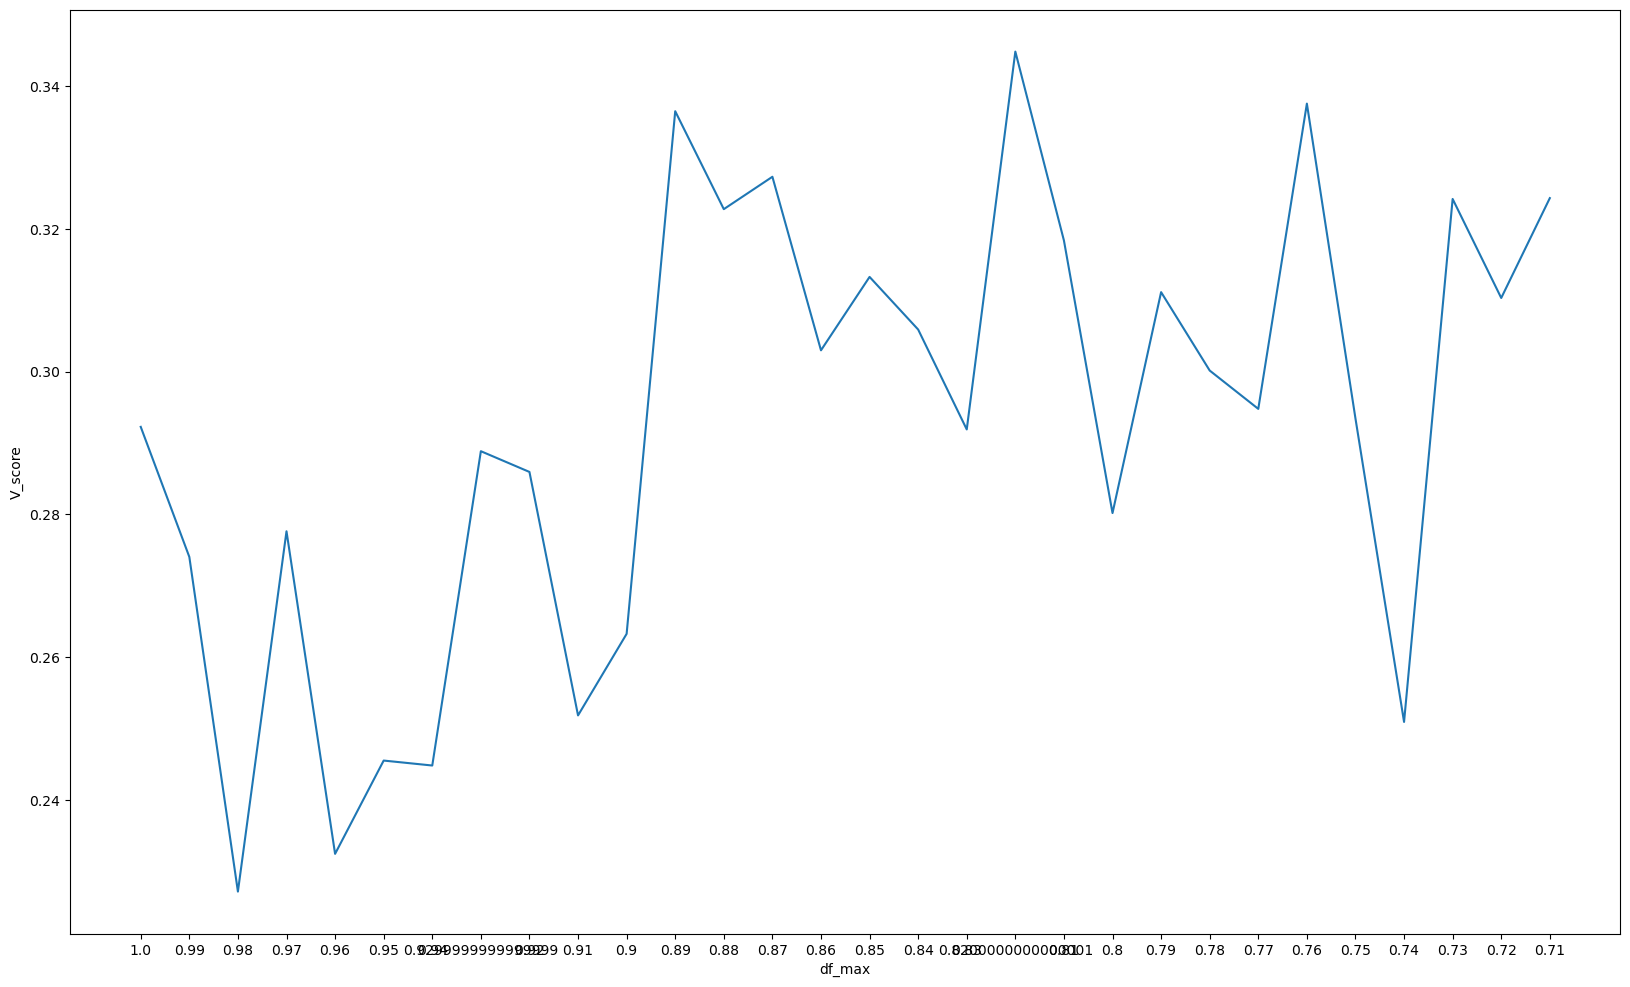

In [21]:
plt.figure(figsize=(20,12))
plt.plot(df_res.index, df_res['v_measure_score'])
plt.xlabel('df_max')
plt.ylabel('V_score')

In [58]:
#test with tfidf and optimized params
custom_stop_words = ['the', 'and', 'is', 'of', 'to', 'in', 'that', 'it', 'on', 'was', 'with', 'as', 'for', 'at', 
    'by', 'an', 'be', 'this', 'which', 'or', 'from', 'but', 'not', 'are', 'he', 'she', 'they', 'we', 'you', 'i', 'me', 'my', 'mine', 'your', 'yours', 'his', 'her', 
    'hers', 'its', 'our', 'ours', 'their', 'theirs', 'whose', 'am', 'is', 'are', 'was', 'were', 'been', 'being', 'at', 'by', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 
    'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
    'under', 'again', 'further', 'then', 'once', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
    'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 
    'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 
    'so', 'than', 'too', 'very', 'can', 'just', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 
    'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 
    'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']

better_vec = TfidfVectorizer(max_df=0.5, min_df=0.4, stop_words=custom_stop_words)
x_train_vec2 = better_vec.fit_transform(x_train)

res = bench_clust(model, x_train_vec2, 'kmeans and tdidf', y_train)
res

c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
kmeans and tdidf,0.001236,0.003168,1.0,0.002324,0.010065,0.003776


In [54]:
sw = better_vec.stop_words_
len(sw)

In [40]:
#Avec LDA

LDA = LatentDirichletAllocation(n_components=20)
y_hat = LDA.fit_transform(x_train_vec2)
LDA.score(x_train_vec2)


-591704.5610082352

In [42]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

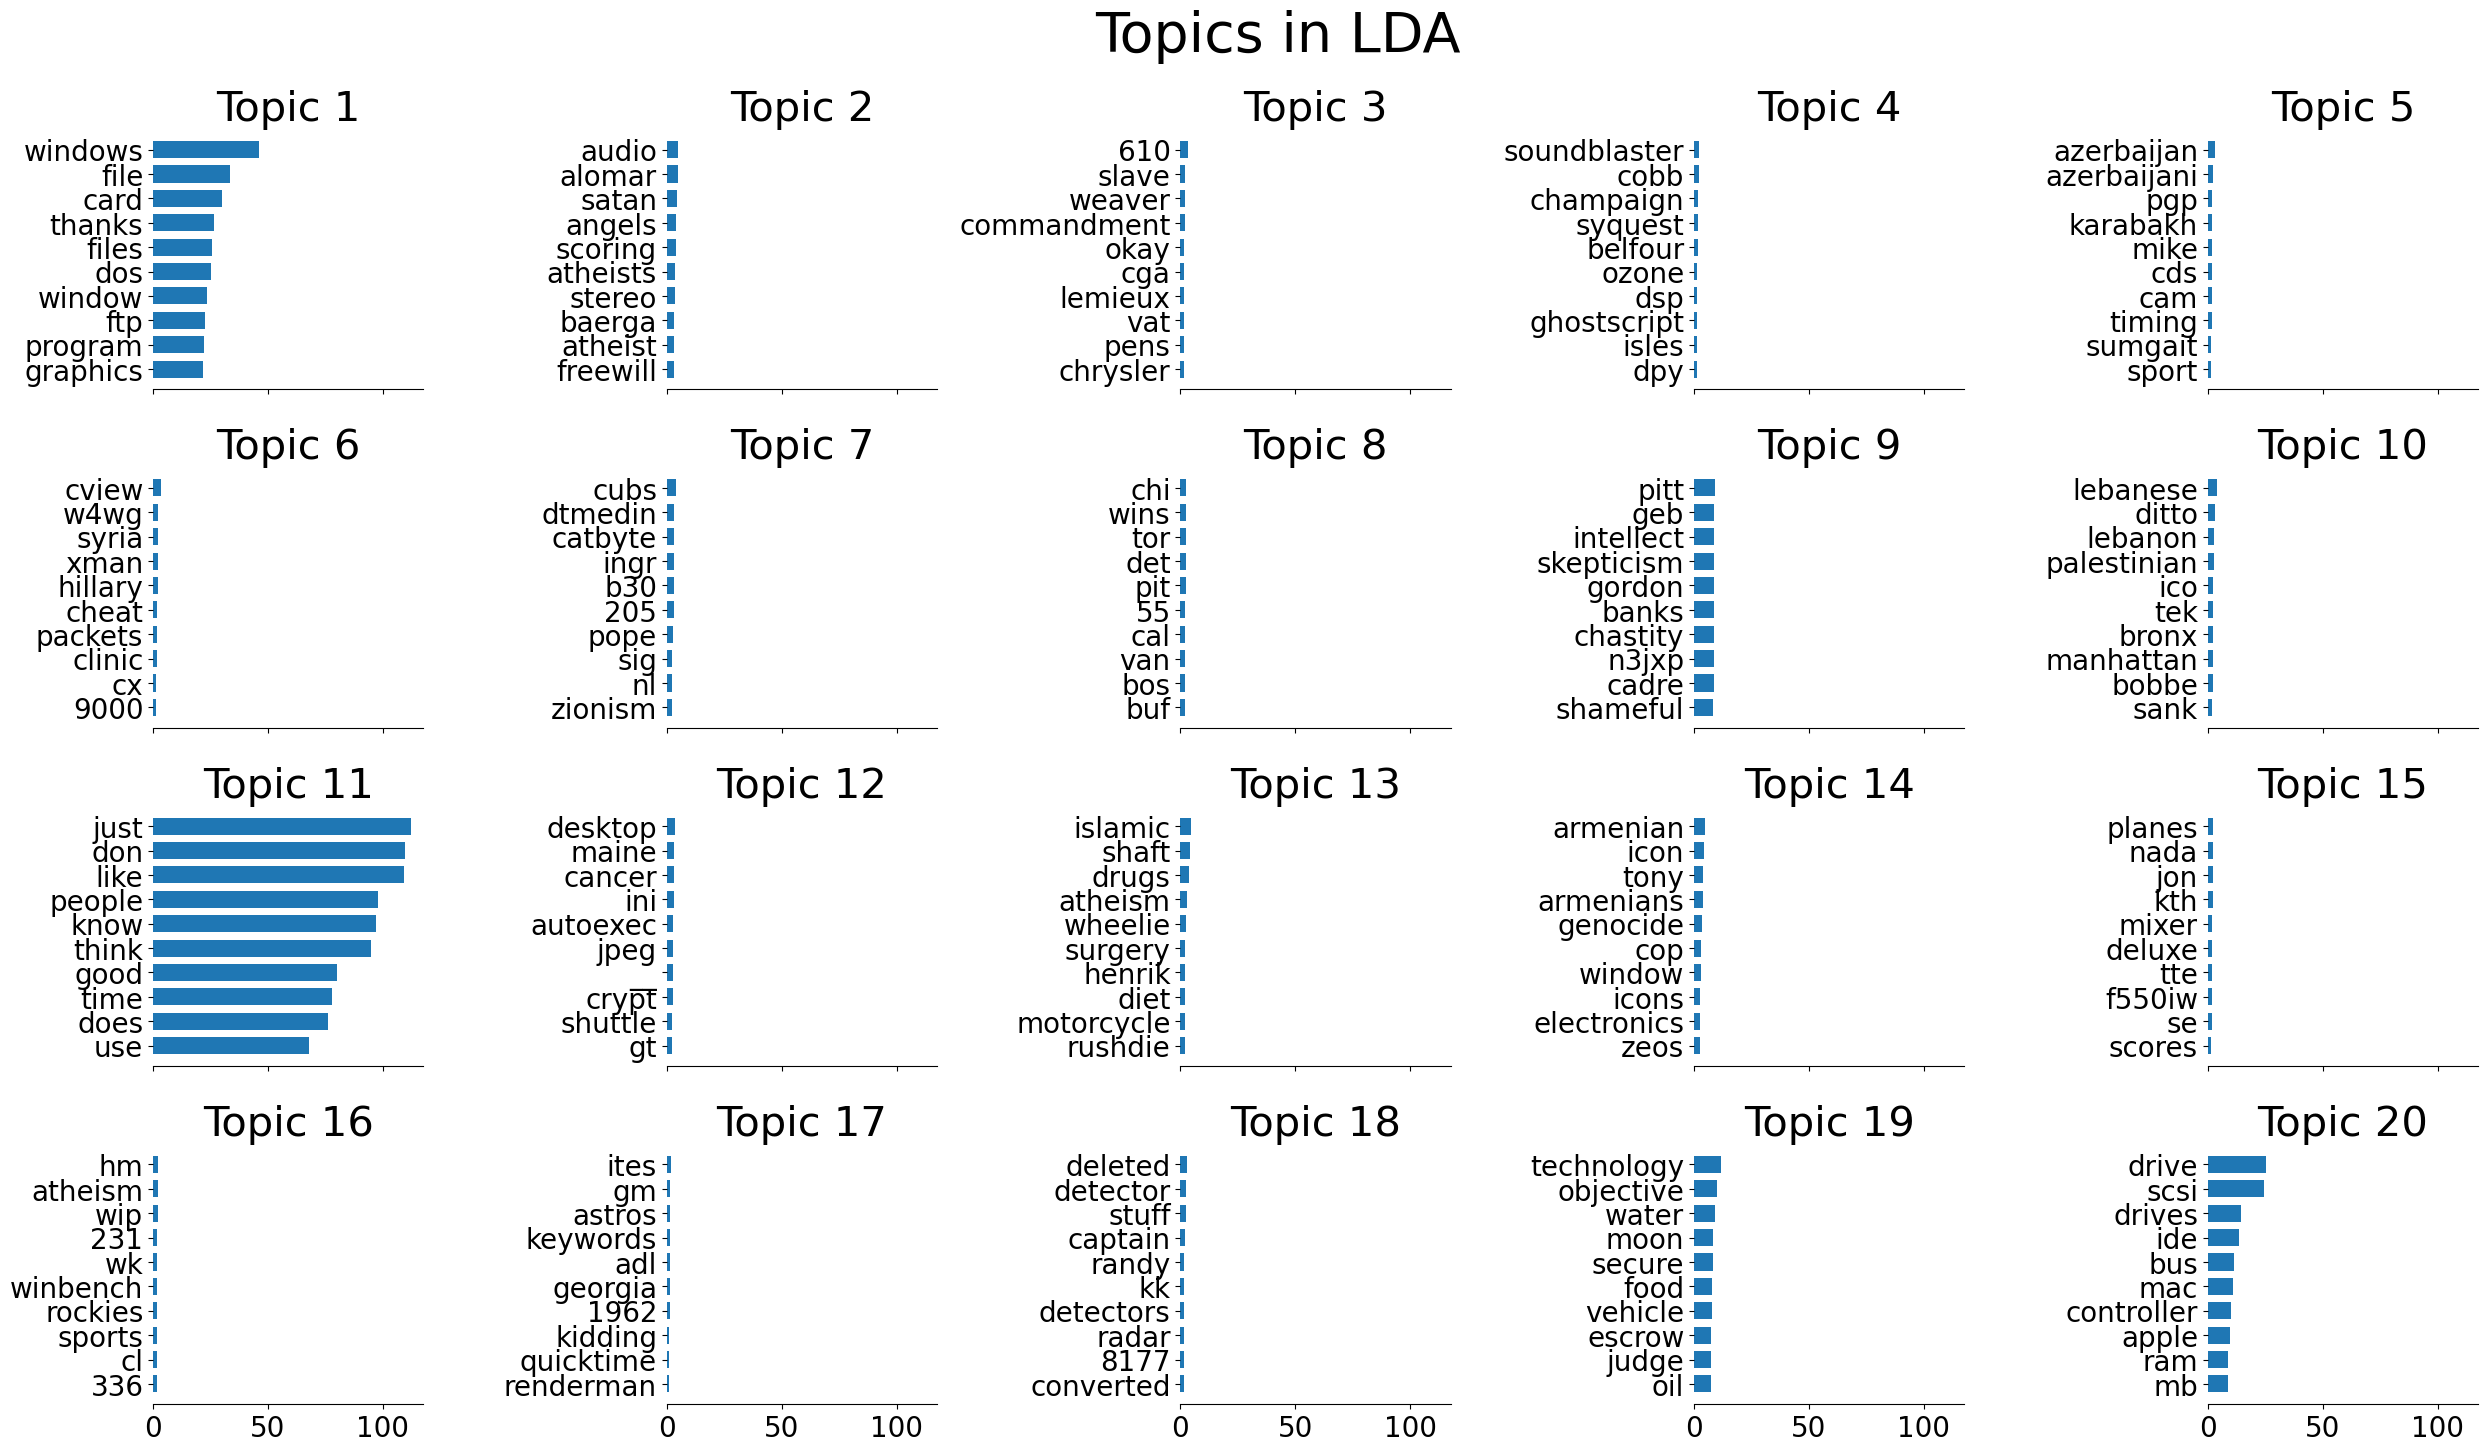

In [43]:
plot_top_words(LDA,tf_feature_names, 10, "Topics in LDA")